In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm_notebook as tqdm
import os
import shutil
import json
from pathlib import Path
import pandas as pd
import csv
from skimage import color

from subtle.subtle_metrics import dice

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 300

def get_rgb(img):
    img = (img - np.min(img))/np.ptp(img)
    return np.dstack((img, img, img))

def overlay_mask(data, label, r=0.2, g=1.0, b=0.2):
    if data.ndim == 2:
        data_rgb = get_rgb(data)
    else:
        data_rgb = data
    
    label_r = label * r
    label_g = label * g
    label_b = label * b
    label_rgb = np.dstack((label_r, label_g, label_b))
    
    data_hsv = color.rgb2hsv(data_rgb)
    label_hsv = color.rgb2hsv(label_rgb)
    
    data_hsv[..., 0] = label_hsv[..., 0]
    data_hsv[..., 1] = label_hsv[..., 1] * 0.55
    
    return color.hsv2rgb(data_hsv)

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

### Step 1: Create files for tumor segmentation from model prediction

- For example `src_data` is symbolic linked from `/mnt/raid/jiang/projects/SubtleGAN/model/MMT/MMTUNetHybrid_GAN_s_c_MMT_epo50_bs24_lrg0.0005_192_opt-adamw/synthetic_images/test/`

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/mmt_seg/seg'
src_dirname = 'src_data'
dest_dirname = 'cases'
data_path = '{}/{}'.format(base_path, src_dirname)
dest_fname = '{base_path}/{dest_dirname}/{cnum}{syn_sfx_dir}/{cnum}{syn_sfx_dir}_{con}.nii.gz'
src_fname = '{base_path}/{src_dirname}/{cnum}/{fname}.nii.gz'

cases = sorted([f.split('/')[-1] for f in glob('{}/*'.format(data_path))])
cons = ['T1', 'T1Gd', 'T2', 'FLAIR']
syn_sfx = [''] + ['_{}_syn'.format(c) for c in cons]

for syn_sfx_dir in syn_sfx:
    for cnum in tqdm(cases, total=len(cases)):
        case_dir = '{}/{}/{}{}'.format(base_path, dest_dirname, cnum, syn_sfx_dir)
        if syn_sfx_dir == '':
            conlist = cons
        else:
            conlist = [c if c != syn_sfx_dir.split('_')[1] else syn_sfx_dir[1:] for c in cons]
        os.makedirs(case_dir)
        for con in conlist:
            fpath_src = src_fname.format(base_path=base_path, src_dirname=src_dirname, cnum=cnum, fname=con)
            fpath_dest = dest_fname.format(base_path=base_path, dest_dirname=dest_dirname, cnum=cnum, 
                                           syn_sfx_dir=syn_sfx_dir, con=con.replace('_syn', ''))
            shutil.copy(fpath_src, fpath_dest)

### Step 2: Create JSON file for segmentation config

In [ ]:
seg_config = {
    'testing_inference': []
}

fpath_tmplt = '/workspace/mmt_seg/{dest_dirname}/{cnum}/{cnum}_{con}.nii.gz'

cases = sorted([f.split('/')[-1] 
                for f in glob('{}/{}/*'.format(base_path, dest_dirname))
               ])
cons = ['T1Gd', 'T1', 'T2', 'FLAIR']
for cnum in tqdm(cases, total=len(cases)):
    img_obj = {
        'image': [fpath_tmplt.format(dest_dirname=dest_dirname, cnum=cnum, con=con) for con in cons]
    }
    seg_config['testing_inference'].append(img_obj)

with open('{}/seg_config_mmg.json'.format(base_path), 'w') as f:
    f.write(json.dumps(seg_config, indent=2))

### Step 3: (from cmdline) - copy the `cases` directory to ngc-ec2 workspace
### Step 4: Run the inference on ngc-ec2 and copy the `pred` folder here (to `/home/srivathsa/projects/studies/gad/mmt_seg`

### Step 5: Rename the pred directories and files (some weird naming convention in the NGC API)

In [ ]:
bpath = '{}/pred'.format(base_path)
pred_dirs = sorted([d.split('/')[-1] for d in glob('{}/*'.format(bpath))])

for pdir in pred_dirs:
    new_pdir = '_'.join(pdir.split('_')[:-1])
    os.rename('{}/{}'.format(bpath, pdir), '{}/{}'.format(bpath, new_pdir))

In [ ]:
nii_files = sorted([f for f in glob('{}/**/*.nii.gz'.format(bpath), recursive=True)])

for fpath_nii in nii_files:
    dir_src = Path(fpath_nii).parent.absolute()
    fname = fpath_nii.split('/')[-1].replace('.nii.gz', '')
    seg_str = fname.split('_')[-1]
    new_fname = '{}_{}.nii.gz'.format('_'.join(fname.split('_')[:-2]), seg_str)
    
    os.rename(fpath_nii, '{}/{}'.format(dir_src, new_fname))

### Step 6: Compute Dice scores and save it to CSV files in `metrics`

In [ ]:
cases = sorted([d.split('/')[-1] for d in glob('{}/src_data/*'.format(base_path))])
pred_dir = '{}/pred'.format(base_path)
cons = ['T1', 'T1Gd', 'T2', 'FLAIR']
syns = ['{}_syn'.format(c) for c in cons]
tumor_classes = ['ET', 'TC', 'WT']
metrics_dir = '{}/metrics'.format(base_path)

for syn in syns:
    metrics_obj = []
    for cnum in tqdm(cases, total=len(cases)):
        case_obj = {'Case': cnum}
        for cls in tumor_classes:
            fpath_gt = '{pdir}/{cnum}/{cnum}_seg{cls}.nii.gz'.format(pdir=pred_dir, cnum=cnum, cls=cls)
            mask_gt = nib.load(fpath_gt).get_fdata()
            
            fpath_pred = '{pdir}/{cnum}_{syn}/{cnum}_{syn}_seg{cls}.nii.gz'.format(
                pdir=pred_dir, cnum=cnum, cls=cls, syn=syn
            )
            mask_pred = nib.load(fpath_pred).get_fdata()
            case_obj[cls] = dice(mask_gt, mask_pred)
        metrics_obj.append(case_obj)
    pd.DataFrame(metrics_obj).to_csv('{}/{}.csv'.format(metrics_dir, syn))

## Signed rank test

In [ ]:
from scipy.stats import wilcoxon
cons = {'T1': 't1', 'T1Gd': 'gd', 'T2': 't2', 'FLAIR': 'fl'}

def compile_dice_scores(dirpath_metrics):    
    df_metrics = []
    
    for kw, suf_str in cons.items():
        mrows = pd.read_csv('{}/{}_syn.csv'.format(dirpath_metrics, kw)).to_dict(orient='records')
        for mrow in mrows:
            crow = [d for d in df_metrics if d['case'] == mrow['Case']]
            if len(crow) == 0:
                df_row = {'case': mrow['Case']}
            else:
                df_row = crow[0]

            df_row['{}_avg'.format(suf_str)] = np.mean([mrow['ET'], mrow['TC'], mrow['WT']])
            
            if len(crow) == 0:
                df_metrics.append(df_row)
    return df_metrics

def get_p_values(bpath, mmt_kw='metrics_mmt', milr_kw='metrics_milr', mmg_kw='metrics_mmgan'):
    df_mmt = compile_dice_scores('{}/{}'.format(bpath, mmt_kw))
    df_mmg = compile_dice_scores('{}/{}'.format(bpath, mmg_kw))
    df_milr = compile_dice_scores('{}/{}'.format(bpath, milr_kw))
    
    p_matrix = []
    for kw, suf_str in cons.items():
        mmt_avg = [d['{}_avg'.format(suf_str)] for d in df_mmt]
        mmg_avg = [d['{}_avg'.format(suf_str)] for d in df_mmg]
        milr_avg = [d['{}_avg'.format(suf_str)] for d in df_milr]
        
        p_matrix.append({
            'Contrast': kw,
            'MM-GAN': wilcoxon(mmt_avg, mmg_avg, alternative='greater')[1],
            'MILR': wilcoxon(mmt_avg, milr_avg, alternative='greater')[1]
        })
    
    return pd.DataFrame(p_matrix)

In [ ]:
df_pvals = get_p_values('/home/srivathsa/projects/studies/gad/mmt_seg/seg')

In [ ]:
df_pvals.to_dict(orient='records')

In [ ]:
fpaths_nii = [f for f in glob('/home/srivathsa/projects/studies/gad/mmt_seg/cases_mmg/**/*.nii.gz', recursive=True)]

for fp in tqdm(fpaths_nii, total=len(fpaths_nii)):
    nbf = nib.load(fp)
    vol = nbf.get_fdata().transpose(1, 0, 2)
    new_nb = nib.Nifti1Image(vol, affine=np.eye(4), header=nbf.header)
    nib.save(new_nb, fp)

### Convert MMT output to 240 x 240

In [ ]:
def pad_back(img):
    img = np.pad(img, pad_width=[(38, 42), (32, 16), (0, 0)])
    return img

src_path = '/mnt/datasets/srivathsa/brats_2021/mmt_syn/synthetic_images/test'
dest_path = '/mnt/datasets/srivathsa/brats_2021/mmt_syn/syn_240x240'
cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(src_path))])

for case_num in tqdm(cases):
    nii_files = sorted([fp for fp in glob('{}/{}/*.nii.gz'.format(src_path, case_num))])
    dpath = os.path.join(dest_path, case_num)
    os.makedirs(dpath, exist_ok=True)
    for fpath_nii in nii_files:
        fname = fpath_nii.split('/')[-1]
        img_nii = nib.load(fpath_nii)
        img_vol = pad_back(img_nii.get_fdata())
        new_nii = nib.Nifti1Image(img_vol, img_nii.affine, img_nii.header)
        nib.save(new_nii, '{}/{}'.format(dpath, fname))

#### Rescale according to nnUNet

In [ ]:
con_map = {'T1': 0, 'T1Gd': 1, 'T2': 2, 'FLAIR': 3}
src_dir = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/imagesVal'
proc_dir = '/mnt/datasets/srivathsa/brats_2021/mmt_syn/syn_240x240'

cases = sorted([c.split('/')[-1] for c in glob('{}/*'.format(proc_dir))])

for cnum in tqdm(cases, total=len(cases)):
    dpath_case = os.path.join(proc_dir, cnum)
    for fpath_nii in glob('{}/*.nii.gz'.format(dpath_case)):
        con_str = fpath_nii.split('/')[-1].replace('.nii.gz', '').replace('_syn', '')
        con_idx = '{:04d}'.format(con_map[con_str])
        fpath_src = os.path.join(src_dir, '{}_{}.nii.gz'.format(cnum, con_idx))
        src_vol = nib.load(fpath_src).get_fdata()
        
        dest_nii = nib.load(fpath_nii)
        dest_vol = dest_nii.get_fdata()
        dest_sc = np.interp(dest_vol, (dest_vol.min(), dest_vol.max()), (src_vol.min(), src_vol.max()))
        new_nii = nib.Nifti1Image(dest_sc, dest_nii.affine, dest_nii.header)
        nib.save(new_nii, fpath_nii)

#### Create missing sequences

In [ ]:
con_list = [0, 1, 2, 3]
ref_path = '/mnt/datasets/srivathsa/brats_2021/mmt_syn/syn_240x240'
base_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/missing'
src_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/imagesVal'

case_nums = sorted([c.split('/')[-1] for c in glob('{}/*'.format(ref_path))])

dirs = sorted([d for d in glob('{}/*'.format(base_path))])

for seq_dir in dirs:
    seq_num = seq_dir.split('/')[-1]
    print('Creating missing sequences for {}...'.format(seq_num))
    seq_list = [int(s) for s in list(seq_num)]
    queries = ['{}/BraTS*_{:04d}.nii.gz'.format(src_path, c) for c in con_list if c not in seq_list]
    
    print('Copy queries...')
    for q in tqdm(queries, total=len(queries)):
        files = glob(q)
        for f in files:
            shutil.copy(f, seq_dir)
    
    print('Creating zero arrays...')
    for mseq in seq_list:
        for cnum in tqdm(case_nums, total=len(case_nums)):
            ref_nii = nib.load(files[0])
            empty_nii = nib.Nifti1Image(np.zeros_like(ref_nii.get_fdata()), ref_nii.affine, ref_nii.header)
            nib.save(empty_nii, '{}/{}_{:04d}.nii.gz'.format(seq_dir, cnum, mseq))

In [ ]:
case = 'BraTS2021_00825'
synth_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/synth'
seq = '0'

fpath_imgs = sorted([fp for fp in glob('{}/{}/{}_*.nii.gz'.format(synth_path, seq, case))])
img_vol = np.array([nib.load(fp).get_fdata() for fp in fpath_imgs])
img_vol = np.array([v / (v.mean() + 1e-8) for v in img_vol])
sl = 72

im_stack = [img_vol[i, ..., sl] for i in np.arange(img_vol.shape[0])]
plt.imshow(np.hstack(im_stack))

In [ ]:
mask1 = nib.load('/mnt/datasets/srivathsa/brats_2021/nnunet/pred/Task500_BraTS2021/BraTS2021_00013.nii.gz').get_fdata()
mask2 = nib.load('/mnt/datasets/srivathsa/brats_2021/nnunet/pred/missing/1/BraTS2021_00013.nii.gz').get_fdata()
plt.imshow(np.hstack([mask1[..., 72], mask2[..., 72]]))

print(dice(mask1, mask2))

#### Create synth sequences

In [ ]:
con_list = [0, 1, 2, 3]
seq_map = {0: 'T1', 1: 'T1Gd', 2: 'T2', 3: 'FLAIR'}
ref_path = '/mnt/datasets/srivathsa/brats_2021/mmt_syn/syn_240x240'
base_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/synth'
src_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/imagesVal'

case_nums = sorted([c.split('/')[-1] for c in glob('{}/*'.format(ref_path))])

dirs = sorted([d for d in glob('{}/*'.format(base_path))])

for seq_dir in dirs:
    seq_num = seq_dir.split('/')[-1]
    print('Creating synth sequences for {}...'.format(seq_num))
    seq_list = [int(s) for s in list(seq_num)]
    queries = ['{}/BraTS*_{:04d}.nii.gz'.format(src_path, c) for c in con_list if c not in seq_list]
    
    print('Copy queries...')
    for q in tqdm(queries, total=len(queries)):
        files = glob(q)
        for f in files:
            shutil.copy(f, seq_dir)
    
    print('Copying synth images...')
    for mseq in seq_list:
        for cnum in tqdm(case_nums, total=len(case_nums)):
            src_syn = os.path.join(ref_path, cnum, '{}_syn.nii.gz'.format(seq_map[mseq]))
            fpath_dst = os.path.join(base_path, '{}/{}/{}_{:04d}.nii.gz'.format(base_path, seq_num, cnum, mseq))
            shutil.copy(src_syn, fpath_dst)

In [ ]:
tr = 'nnUNetTrainerV2BraTSRegions_DA4_BN_BD_largeUnet_Groupnorm'
cmd = 'CUDA_VISIBLE_DEVICES=3 nnUNet_predict -i {} -o {} -t 500 -m 3d_fullres -tr {} --save_npz --folds all;'

missing_dir = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/missing'
synth_dir = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/synth'
out_dir_m = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/missing'
out_dir_s = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/synth'

seqs = sorted([d.split('/')[-1] for d in glob('{}/*'.format(missing_dir))])

for seq in seqs:
    ip_dir = os.path.join(missing_dir, seq)
    op_dir = os.path.join(out_dir_m, seq)
    print(cmd.format(ip_dir, op_dir, tr))
    
for seq in seqs:
    ip_dir = os.path.join(synth_dir, seq)
    op_dir = os.path.join(out_dir_s, seq)
    print(cmd.format(ip_dir, op_dir, tr))

### nnUNet Dice Score

In [ ]:
full_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/Task500_BraTS2021'
miss_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/missing'
synt_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/synth'

cases = sorted([c.split('/')[-1].replace('.nii.gz', '') for c in glob('{}/*.nii.gz'.format(full_pred))])
seqs = sorted([s.split('/')[-1] for s in glob('{}/*'.format(miss_pred))])

metric_list = []

for seq_num in seqs:
    for case in tqdm(cases, total=len(cases)):
        pred1 = nib.load('{}/{}.nii.gz'.format(full_pred, case)).get_fdata()
        pred1 = (pred1 != 0)
        pred2 = nib.load('{}/{}/{}.nii.gz'.format(miss_pred, seq_num, case)).get_fdata()
        pred2 = (pred2 != 0)
        pred3 = nib.load('{}/{}/{}.nii.gz'.format(synt_pred, seq_num, case)).get_fdata()
        pred3 = (pred3 != 0)

        dice_miss = dice(pred1, pred2)
        dice_synth = dice(pred1, pred3)
        
        metric_list.append({'Case': case, 'Sequence': str(seq_num), 'Dice Miss': dice_miss, 'Dice Synth': dice_synth})

# df_metrics = pd.DataFrame(metric_list)

In [ ]:
df_metrics = pd.DataFrame(metric_list)

In [ ]:
df_metrics.to_csv('/mnt/datasets/srivathsa/brats_2021/nnunet/pred/synth_miss.csv', sep='\t', quoting=csv.QUOTE_ALL)

In [2]:
df_metrics = pd.read_csv('/mnt/datasets/srivathsa/brats_2021/nnunet/pred/synth_miss.csv', 
                         index_col=0, sep='\t', quoting=csv.QUOTE_NONNUMERIC, 
                         dtype={'Sequence': object, 'Dice Miss': float, 'Dice Synth': float})

df_mean = df_metrics[df_metrics['Sequence'].isin(['012', '013', '023', '123'])].groupby('Sequence').mean()
df_mean

,Dice Miss,Dice Synth
Sequence,,
012,0.184564,0.956287
013,0.471331,0.913428
023,0.364711,0.928173
123,0.084865,0.918290


In [3]:
df_mean = df_metrics.groupby('Sequence').mean()
df_mean

,Dice Miss,Dice Synth
Sequence,,
0,0.980675,0.990010
01,0.952049,0.967980
012,0.184564,0.956287
013,0.471331,0.913428
02,0.894225,0.973190
023,0.364711,0.928173
03,0.591928,0.924757
1,0.957095,0.969355
12,0.844478,0.957175


In [6]:
seq = '1'
df_filt = df_metrics[df_metrics['Sequence'] == seq].sort_values(by='Dice Miss')
df_filt.head(25)

,Case,Sequence,Dice Miss,Dice Synth
1559.0,BraTS2021_00213,1,0.454641,0.487059
1642.0,BraTS2021_01689,1,0.776884,0.884293
1676.0,BraTS2021_01723,1,0.789136,0.789366
1718.0,BraTS2021_01765,1,0.830220,0.949080
1679.0,BraTS2021_01726,1,0.834660,0.871270
1592.0,BraTS2021_00560,1,0.843073,0.937241
1672.0,BraTS2021_01719,1,0.850523,0.911863
1618.0,BraTS2021_00997,1,0.855289,0.946455
1566.0,BraTS2021_00323,1,0.857976,0.973132
1704.0,BraTS2021_01751,1,0.861809,0.952290


In [7]:
synth_dir = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/synth'
data_path = '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/imagesVal'
full_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/Task500_BraTS2021'
miss_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/missing'
synt_pred = '/mnt/datasets/srivathsa/brats_2021/nnunet/pred/synth'

In [8]:
def plot_tumor_mask(case_num, sl, seq, overlay_on=1, mode='full'):
    data = nib.load('{}/{}_{:04d}.nii.gz'.format(data_path, case_num, overlay_on)).get_fdata()[..., sl]
    data = np.rot90(data, k=3)
    data = data[30:-30, 50:-50]
    
    if mode == 'full':
        pred_path = full_pred
    elif mode == 'miss':
        pred_path = miss_pred
    elif mode == 'synth':
        pred_path = synt_pred
    if mode == 'full':
        seg = nib.load('{}/{}.nii.gz'.format(pred_path, case_num)).get_fdata()[..., sl]
        seg = np.rot90(seg, k=3)
        seg = seg[30:-30, 50:-50]
        mask = overlay_mask(data, seg, r=0, g=1.0, b=0) 
    else:
        disp_img = []
        for seq_str in seq:
            seg = nib.load('{}/{}/{}.nii.gz'.format(pred_path, seq_str, case_num)).get_fdata()[..., sl]
            seg = np.rot90(seg, k=3)
            seg = seg[30:-30, 50:-50]
            disp_img.append(overlay_mask(data, seg, r=0, g=1.0, b=0))
            
            df_filt = df_metrics.query(f'Sequence == "{seq_str}" and Case == "{case_num}"')
            ds_dict = df_filt.to_dict(orient='records')[0]
            if mode == 'miss':
                print(ds_dict['Dice Miss'])
            else:
                print(ds_dict['Dice Synth'])
            
        mask = np.hstack(disp_img)
    plt.imshow(mask)
    plt.axis('off')

0.7893655535442602


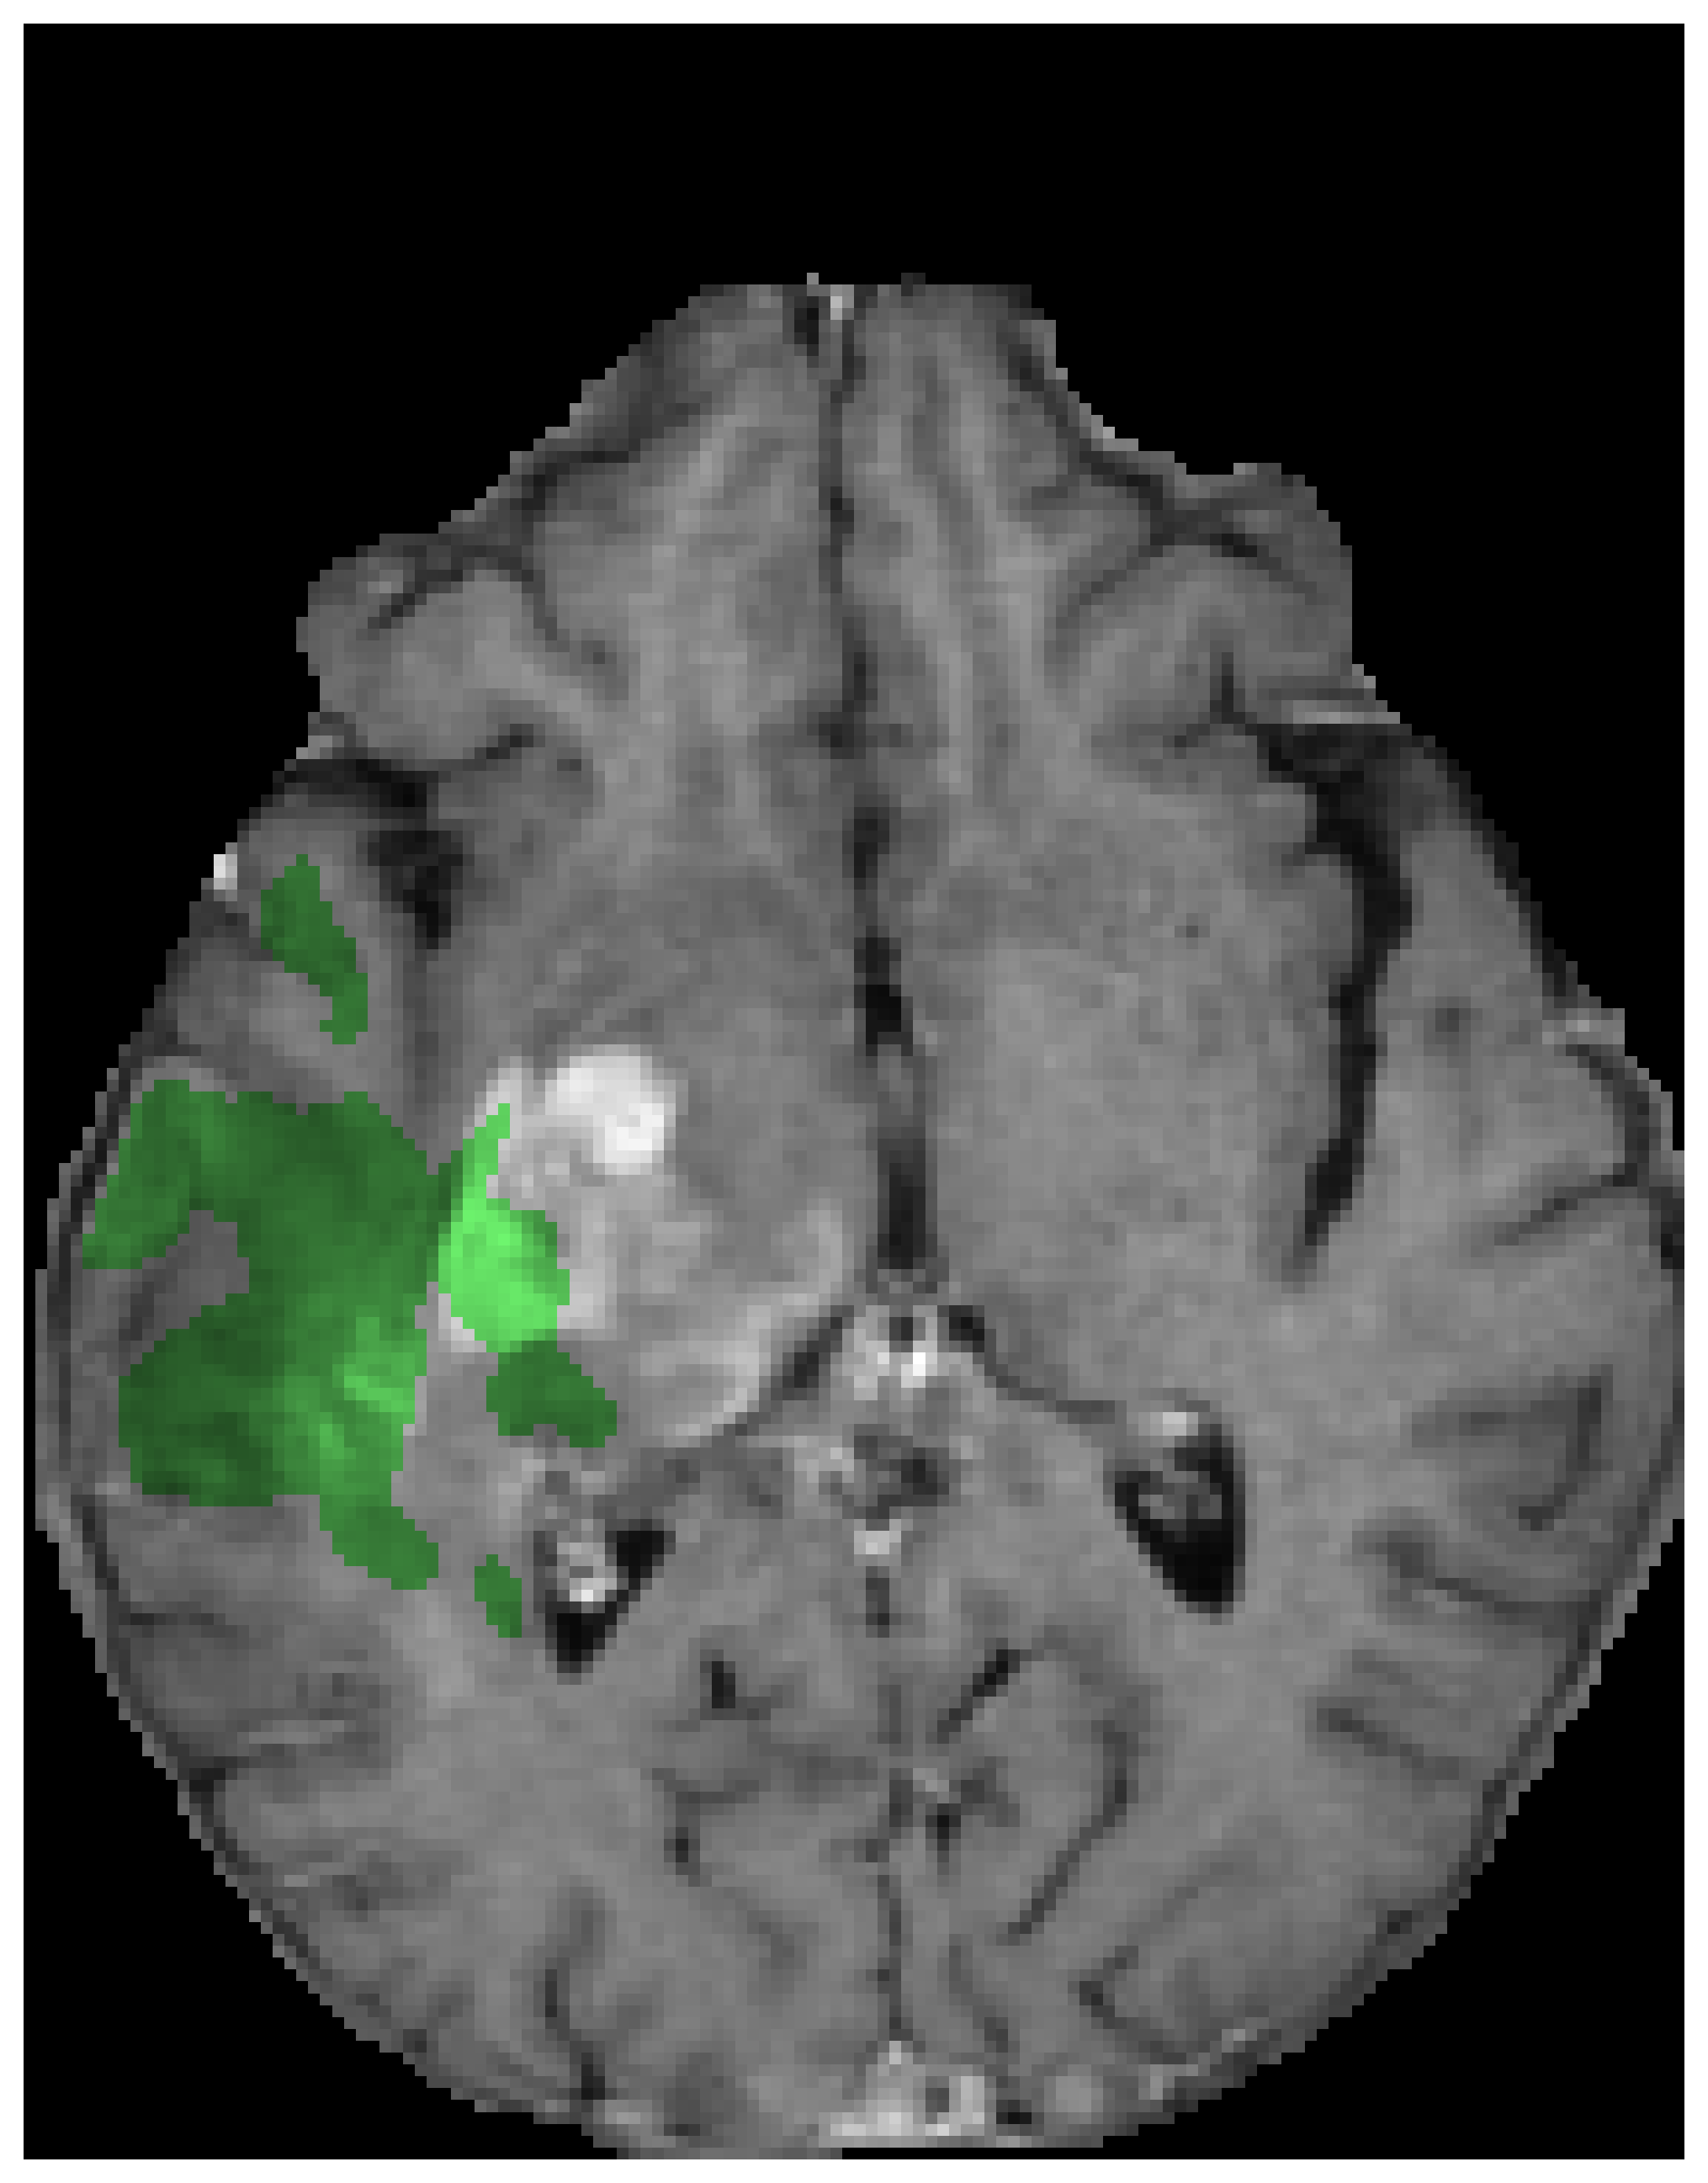

In [10]:
# plot_tumor_mask(case_num='BraTS2021_00592', sl=85, mode='synth', seq=['01', '02', '03', '12', '13', '23'])
plot_tumor_mask(case_num='BraTS2021_01723', sl=65, mode='synth', seq=['1'])

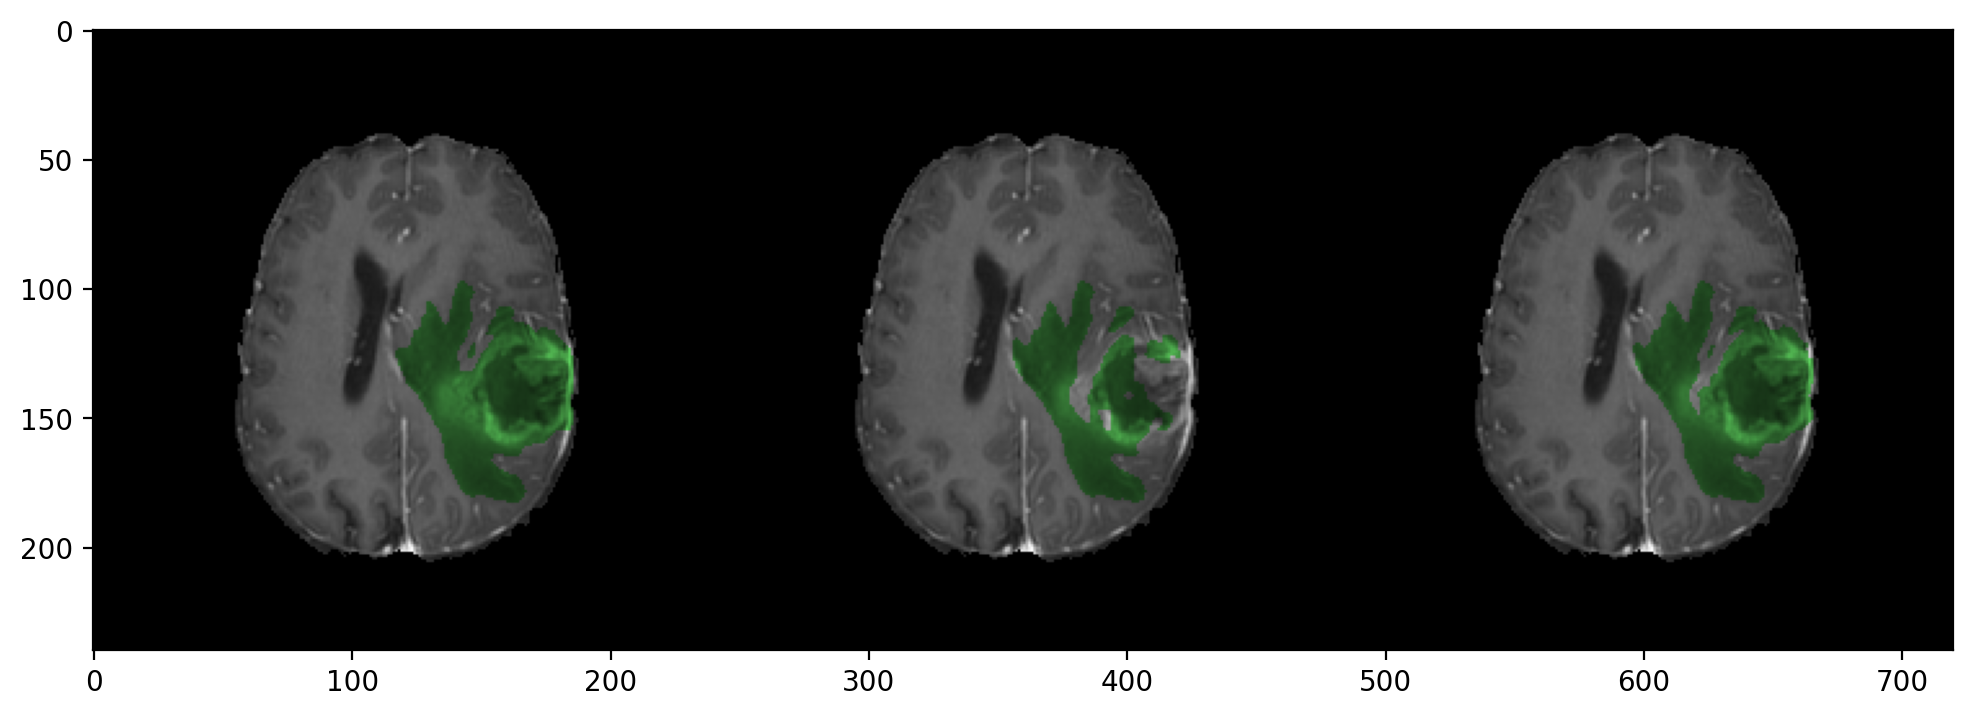

In [13]:
case_num = 'BraTS2021_00592'
sl = 85

data1 = nib.load('{}/{}_0001.nii.gz'.format(data_path, case_num)).get_fdata()[..., sl]
data1 = np.rot90(data1, k=3)
data2 = nib.load('{}/{}/{}_0001.nii.gz'.format(synth_dir, seq, case_num)).get_fdata()[..., sl]
data2 = np.rot90(data2, k=3)
seg1 = nib.load('{}/{}.nii.gz'.format(full_pred, case_num)).get_fdata()[..., sl]
seg1 = np.rot90(seg1, k=3)
seg2 = nib.load('{}/{}/{}.nii.gz'.format(miss_pred, seq, case_num)).get_fdata()[..., sl]
seg2 = np.rot90(seg2, k=3)
seg3 = nib.load('{}/{}/{}.nii.gz'.format(synt_pred, seq, case_num)).get_fdata()[..., sl]
seg3 = np.rot90(seg3, k=3)

mask1 = overlay_mask(data1, seg1, g=1.0, r=0, b=0)
mask2 = overlay_mask(mask1, seg2, g=1.0, r=0, b=0)
mask3 = overlay_mask(mask2, seg3, g=1.0, r=0, b=0)

disp_img = np.hstack([mask1, mask2, mask3])

plt.imshow(disp_img)

In [19]:
df_filt = df_metrics.query(f'Sequence == "{seq}" and Case == "{case_num}"')
df_filt.to_dict(orient='records')

[{'Case': 'BraTS2021_00592',
  'Sequence': '01',
  'Dice Miss': 0.7709333532927729,
  'Dice Synth': 0.9490036308880496}]

In [ ]:
syn = nib.load(
    '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/synth/2/BraTS2021_00213_0002.nii.gz'
).get_fdata()

dat = nib.load(
    '/mnt/datasets/srivathsa/brats_2021/nnunet/raw/nnUNet_raw_data/Task500_BraTS2021/imagesVal/BraTS2021_00213_0002.nii.gz'
).get_fdata()

In [ ]:
plt.imshow(np.hstack([dat[..., 110] - syn[..., 110]]))